#### (Versión Beta 01 - Agosto 2019)

# Modelado de Sismogramas Sintéticos de una Falla Normal

* [Douglas Alberto Gómez Reyes](agomezr@imp.mx) - Dirección de Servicios en Exploración y Producción, IMP
* [Sergio Chávez Pérez](sergio.chavezp@gmail.com) - Dirección de Tecnología de Producto, IMP
* [Luis Chávez Pensabé](luischavez117.c@gmail.com) - Escuela Superior de Ingeniería y Arquitectura, Ciencias de la Tierra, IPN

## Instrucciones

Este cuaderno de trabajo documenta el ejercicio numérico para construir un modelo de falla normal y obtener su respuesta sísmica. Lo anterior, como parte del resumen del trabajo _Modelado de Sismogramas Sintéticos con Herramientas de Código Abierto_, sometido al programa técnico del [70 Aniversario de la Asociación Mexicana de Geólogos Petroleros A.C.](https://www.amgp.org/eventos/70-aniversario-amgp/123) El lector interesado, puede consultar una copia del resumen sometido [aquí](https://drive.google.com/file/d/1l5zv33OlAsOXlxULSvA4IhSXK1EBOfe0/view?usp=sharing).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bruges.filters import ricker
from wiggle.wiggle import wiggle
from scipy import interpolate

%matplotlib inline

## Construcción del modelo

Con base en el trabajo de [Bianco (2018)](https://github.com/agile-geoscience/notebooks/blob/master/To_build_a_better_wedge.ipynb), adaptamos y desarrollamos la secuencia para construir un modelo de falla normal. El bloque de fallas se construye en el dominio del modelo y posteriormente se convierte al dominio de los datos.  

Las unidades en las direcciones horizontal y vertical son en metros, y se ha considerado un subespacio de 1000 x 600 m, con 5 capas horizontales.

In [2]:
geometria = {'za1':200, 'zan':100, 
             'zb1':250, 'zb2':100, 'zb3':100, 'zb4':100,
             'xa1':400/4, 'xa2':250/4, 'n':100/4,  'dx':1, 'dz':1,
             'zmin':0, 'zmax':600, 'xmin':0, 'xmax': 1000/4}

In [3]:
def superficie_01(**kw):
    '''Línea 01 del bloque caído (lado derecho de la falla)'''
    x = kw['xmax']-kw['xmin']
    t0 = kw['za1']
    x2 = np.arange(0, x - (kw['xa1'] + kw['xa2'] + 3*kw['n']), kw['dx'])
    m = (kw['zb1']-kw['za1']) / len(x2)
    seg1 = np.zeros(int(kw['xa1']/kw['dx']))
    seg2 =  m * x2
    seg3 = np.ones(int((kw['xa2']+ 3*kw['n'])/kw['dx']))
    interfase = t0 + np.concatenate((seg1, seg2, 1+seg2[-1]+seg3))
    return interfase

def superficie_02(**kw):
    '''Línea 02 del bloque caído (lado derecho de la falla)'''
    x = kw['xmax'] - kw['xmin']
    t0 = kw['za1'] 
    x2 = np.arange(0, x - (kw['xa1'] + kw['xa2'] + 2*kw['n']), kw['dx'])
    m = (kw['zb1']+kw['zb2']-kw['za1']) / len(x2)
    seg1 = np.zeros(int(kw['xa1']/kw['dx']))
    seg2 =  m * x2
    seg3 = np.ones(int((kw['xa2'] + 2*kw['n'])/kw['dx']))
    interfase = t0 + np.concatenate((seg1, seg2, 1+seg2[-1]+seg3))
    return interfase

def superficie_03(**kw):
    '''Línea 03 del bloque caído (lado derecho de la falla)'''
    x = kw['xmax'] - kw['xmin']
    t0 = kw['za1'] 
    x2 = np.arange(0, x - (kw['xa1'] + kw['xa2'] + 1*kw['n']), kw['dx'])
    m = (kw['zb1']+kw['zb2']+kw['zb3']-kw['za1']) / len(x2)
    seg1 = np.zeros(int(kw['xa1']/kw['dx']))
    seg2 =  m * x2
    seg3 = np.ones(int((kw['xa2'] + 1*kw['n'])/kw['dx']))
    interfase = t0 + np.concatenate((seg1, seg2, 1+seg2[-1]+seg3))
    return interfase

def superficie_04(**kw):
    '''Línea 04 del bloque caído (lado derecho de la falla)'''
    x = kw['xmax'] - kw['xmin']
    t0 = kw['za1'] 
    x2 = np.arange(0, x - (kw['xa1'] + kw['xa2']), kw['dx'])
    m = (kw['zb1']+kw['zb2']+kw['zb3']+kw['zb4']-kw['za1']) / len(x2)
    seg1 = np.zeros(int(kw['xa1']/kw['dx']))
    seg2 =  m * x2
    seg3 = np.ones(int((kw['xa2'])/kw['dx']))
    interfase = t0 + np.concatenate((seg1, seg2, 1+seg2[-1]+seg3))
    return interfase

def superficie_05(**kw):
    '''Línea 05 del bloque elevado (lado izquierdo de la falla)'''
    x = kw['xmax'] - kw['xmin']
    t0 = kw['za1']
    x2 = np.arange(0, 4*kw['n'], kw['dx'])
    m = (kw['zmax'] - kw['za1']) / len(x2)
    seg1 = np.zeros(int((kw['xa1']/kw['dx'])))
    seg2 =  m * x2
    seg3 = np.ones(int((kw['xa2']-0.5*kw['n'])/kw['dx']))
    interfase = t0 + np.concatenate((seg1, seg2, 1+seg2[-1]+seg3))
    return interfase

def superficie_06(**kw):
    '''Línea 06 del bloque elevado (lado izquierdo de la falla)'''
    x = kw['xmax'] - kw['xmin']
    t0 = kw['za1'] + kw['zan']
    x2 = np.arange(0, 3*kw['n'], kw['dx'])
    m = (kw['zmax']-(kw['za1']+kw['zan'])) / len(x2)
    seg1 = np.zeros(int((kw['xa1']+kw['n'])/kw['dx']))
    seg2 =  m * x2
    seg3 = np.ones(int((kw['xa2']-0.5*kw['n'])/kw['dx']))
    interfase = t0 + np.concatenate((seg1, seg2, 1+seg2[-1]+seg3))
    return interfase

def superficie_07(**kw):
    '''Línea 07 del bloque elevado (lado izquierdo de la falla)'''
    x = kw['xmax'] - kw['xmin']
    t0 = kw['za1'] + 2*kw['zan']
    x2 = np.arange(0, 2*kw['n'], kw['dx'])
    m = (kw['zmax']-(kw['za1']+2*kw['zan'])) / len(x2)
    seg1 = np.zeros(int((kw['xa1']+2*kw['n'])/kw['dx']))
    seg2 =  m * x2
    seg3 = np.ones(int((kw['xa2']-0.5*kw['n'])/kw['dx']))
    interfase = t0 + np.concatenate((seg1, seg2, 1+seg2[-1]+seg3))
    return interfase

def superficie_08(**kw):
    '''Línea 08 del bloque elevado (lado izquierdo de la falla)'''
    x = kw['xmax'] - kw['xmin']
    t0 = kw['za1'] + 3*kw['zan']
    x2 = np.arange(0, 1*kw['n'], kw['dx'])
    m = (kw['zmax']-(kw['za1']+3*kw['zan'])) / len(x2)
    seg1 = np.zeros(int((kw['xa1']+3*kw['n'])/kw['dx']))
    seg2 =  m * x2
    seg3 = np.ones(int((kw['xa2']-0.5*kw['n'])/kw['dx']))
    interfase = t0 + np.concatenate((seg1, seg2, 1+seg2[-1]+seg3))
    return interfase

def falla_normal(kwargs):
    '''Ensable de las líneas'''
    horizonte1 = superficie_01(**kwargs)
    horizonte2 = superficie_02(**kwargs)
    horizonte3 = superficie_03(**kwargs)
    horizonte4 = superficie_04(**kwargs)
    horizonte5 = superficie_05(**kwargs)
    horizonte6 = superficie_06(**kwargs)
    horizonte7 = superficie_07(**kwargs)
    horizonte8=  superficie_08(**kwargs)
    return horizonte1, horizonte2, horizonte3, horizonte4, horizonte5, horizonte6, horizonte7, horizonte8

def modelo_geo(ax, hor1, hor2, hor3, hor4, hor5, hor6, hor7, hor8, **kw):
    '''Construcción del modelo de falla normal'''
    ax.plot(hor1,'-k', lw = 0.4)
    ax.plot(hor2,'-k', lw = 0.4)
    ax.plot(hor3,'-k', lw = 0.4)
    ax.plot(hor4,'-k', lw = 0.4)
    ax.plot(hor5,'-k', lw = 0.1)
    ax.plot(hor6,'-k', lw = 0.4)
    ax.plot(hor7,'-k', lw = 0.4)
    ax.plot(hor8,'-k', lw = 0.4)
    ax.set_ylim(0,600)
    ax.set_xlim(kw['xmin'],kw['xmax'])
    ax.invert_yaxis()

## Modelo de falla normal (malla 2D)

Construimos una matriz


> $ M_{600,250} = 
        \begin{pmatrix}
       \ m_{1,1}   &  m_{1,2}   & \cdots &  m_{1,250}       \\
       \ m_{2,1}   &  m_{2,2}   & \cdots &  m_{2,250}       \\
       \vdots      &  \vdots    & \ddots &  \vdots          \\
       \ m_{600,1} &  m_{600,2} & \cdots &  m_{600,250}   
     \end{pmatrix}
$

y le asignamos la geometría del modelo de falla normal.

In [4]:
hor1, hor2, hor3, hor4, hor5, hor6, hor7, hor8 = falla_normal(geometria)

In [5]:
def malla(**kw):
    hor1, hor2, hor3, hor4, hor5, hor6, hor7, hor8 = falla_normal(geometria)
    t = np.arange(kw['zmin'], kw['zmax'], kw['dz'])
    x = np.arange(kw['xmin'], kw['xmax'], kw['dx'])
    xm, ym = np.meshgrid(x, t, sparse=False, indexing='ij')
    return xm, ym

In [6]:
xm, ym = malla(**geometria)

In [7]:
modelo_capas = {'hor0':  ym.T <= hor1,
                'hor1': (ym.T >= hor1) & (ym.T <= hor2),
                'hor2': (ym.T >= hor2) & (ym.T <= hor3),
                'hor3': (ym.T >= hor3) & (ym.T <= hor4),
                'hor4': (ym.T >= hor4) & (ym.T <= hor5),
                'hor5': (ym.T >= hor5) & (ym.T <= hor6),
                'hor6': (ym.T >= hor6) & (ym.T <= hor7),
                'hor7': (ym.T >= hor7) & (ym.T <= hor8),
                'hor8':  ym.T >= hor8}

parametros = {'hor0': 1, 
              'hor1':2, 'hor2':3, 'hor3':4, 'hor4':5, 'hor5':2, 'hor6':3, 'hor7':4, 'hor8':5}

In [8]:
d = ym.T.copy()
for name, cond in modelo_capas.items():
    d[cond] = parametros[name]

## Modelo de velocidad, impedancia acústica y reflectividad en el dominio de la profundidad

Asignación de parámetros de velocidad y densidad volumétrica.Los valores fueron tomados de [Chopra y Castagna (2014)](https://library.seg.org/doi/book/10.1190/1.9781560803201) , páginas 11 y 12. 

In [9]:
vp = np.array([1850, 2400, 3095, 4050, 2645]) 
rho = np.array([2280, 1950, 2400, 2210, 2290]) 
imp = vp*rho

In [10]:
print( 'Velocidad de propagación de las capas: ', vp, '[m/s]')
print( 'Impedancia acústica de las capas: ', imp, '[kg/m^2s^2]')

Velocidad de propagación de las capas:  [1850 2400 3095 4050 2645] [m/s]
Impedancia acústica de las capas:  [4218000 4680000 7428000 8950500 6057050] [kg/m^2s^2]


In [11]:
modelo_vel = d.copy()
modelo_vel[d == 1] = vp[0]
modelo_vel[d == 2] = vp[1]
modelo_vel[d == 3] = vp[2]
modelo_vel[d == 4] = vp[3]
modelo_vel[d == 5] = vp[4]

In [12]:
modelo_den = d.copy()
modelo_den[d == 1] = rho[0]
modelo_den[d == 2] = rho[1]
modelo_den[d == 3] = rho[2]
modelo_den[d == 4] = rho[3]
modelo_den[d == 5] = rho[4]

In [13]:
modelo_imp = d.copy()
modelo_imp[d == 1] = imp[0]
modelo_imp[d == 2] = imp[1]
modelo_imp[d == 3] = imp[2]
modelo_imp[d == 4] = imp[3]
modelo_imp[d == 5] = imp[4]

In [14]:
sr = (modelo_imp[1:] - modelo_imp[:-1]) / (modelo_imp[1:] + modelo_imp[:-1])
maxsr = np.amax(abs(sr))

In [15]:
print('Valor máximo de reflectividad', np.round(maxsr,3), '[1]')

Valor máximo de reflectividad 0.313 [1]


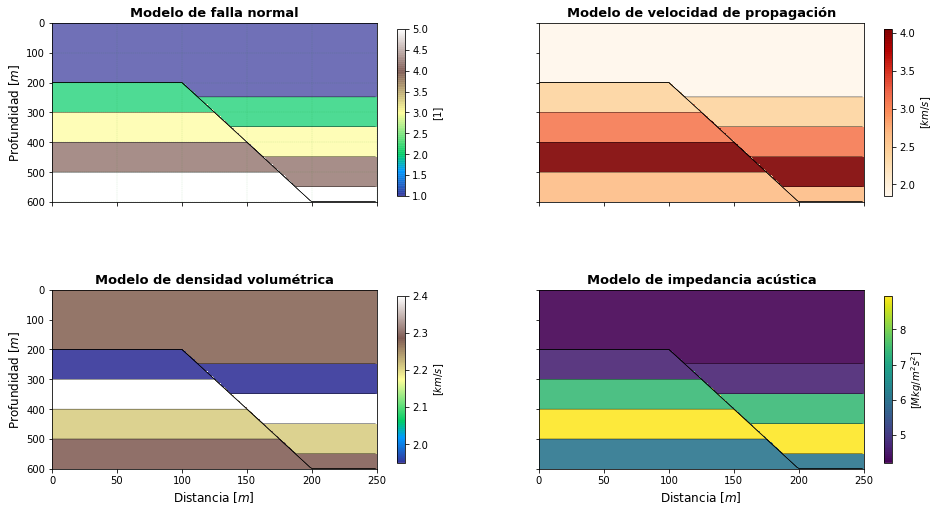

In [16]:
fig = plt.figure(figsize=[16,9])

ax = fig.add_subplot(221)
plt.imshow(d, cmap = 'terrain', alpha=0.7, aspect = 0.23)
cbar = plt.colorbar(shrink=0.75)
cbar.set_label('[1]', fontsize = 10, weight = 'normal')
plt.title('Modelo de falla normal', fontsize = 13, weight = 'semibold' )
plt.ylabel('Profundidad $[m]$', fontsize = 12, weight = 'normal')
ax.set_xticklabels('')
plt.ylim(600,0)
plt.grid(True, alpha = 0.2, lw = 0.4, color = 'g', ls = '--')
modelo_geo(ax, hor1, hor2, hor3, hor4, hor5, hor6, hor7, hor8, **geometria)

ax = fig.add_subplot(222)
im = plt.imshow(modelo_vel/1000, cmap='OrRd', alpha = 0.9, aspect = 0.23)
cbar = plt.colorbar(shrink=0.75)
cbar.set_label('$[km/s]$', fontsize = 10, weight = 'normal')
plt.title('Modelo de velocidad de propagación', fontsize = 13, weight = 'semibold')
ax.set_xticklabels('')
ax.set_yticklabels('')
modelo_geo(ax, hor1, hor2, hor3, hor4, hor5, hor6, hor7, hor8, **geometria)

ax = fig.add_subplot(223)
im = plt.imshow(modelo_den/1000, cmap='terrain', alpha = 0.9, aspect = 0.23)
cbar = plt.colorbar(shrink=0.75)
cbar.set_label('$[km/s]$', fontsize = 10, weight = 'normal')
plt.title('Modelo de densidad volumétrica', fontsize = 13, weight = 'semibold')
plt.xlabel('Distancia $[m]$', fontsize = 12, weight = 'normal')
plt.ylabel('Profundidad $[m]$', fontsize = 12, weight = 'normal')
plt.ylim(600,0)
modelo_geo(ax, hor1, hor2, hor3, hor4, hor5, hor6, hor7, hor8, **geometria)

ax = fig.add_subplot(224)
im = plt.imshow(modelo_imp/1000000, cmap = 'viridis', alpha = 0.9, aspect = 0.23)
cbar = plt.colorbar(shrink=0.75)
cbar.set_label('$[Mkg/m^2s^2]$', fontsize = 10, weight = 'normal')
plt.title('Modelo de impedancia acústica', fontsize = 13, weight = 'semibold')
plt.xlabel('Distancia $[m]$', fontsize = 12, weight = 'normal')
ax.set_yticklabels('')
modelo_geo(ax, hor1, hor2, hor3, hor4, hor5, hor6, hor7, hor8, **geometria)

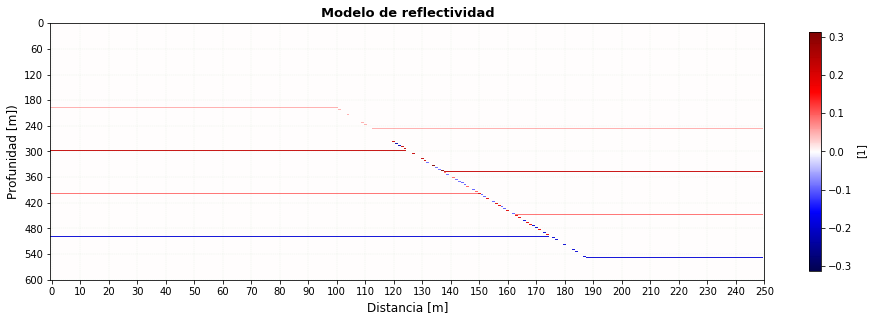

In [17]:
plt.figure(figsize=[16,8])

ax = plt.subplot(111)
im = plt.imshow(sr, cmap='seismic', vmax = maxsr, vmin = -maxsr, alpha = 0.9, aspect = 0.15)
cbar = plt.colorbar(shrink = 0.55)
cbar.set_label('$[1]$', fontsize = 10, weight = 'normal')
_ = plt.title('Modelo de reflectividad', fontsize = 13, weight = 'semibold')
_ = plt.xlabel('Distancia [m]', fontsize = 12)
_ = plt.ylabel('Profunidad [m])', fontsize = 12)
_ = plt.yticks(np.linspace(0,600,11))
_ = plt.xticks(np.linspace(0,250,26))
_ = plt.grid(True, alpha = 0.1, lw = 0.4, color = 'g', ls = '--')

## Modelo de velocidad, impedancia acústica y reflectividad en el dominio del tiempo

Para construir el modelo de falla en el dominio del tiempo, calculamos el modelo de tiempo doble de viaje, y estimamos el valor máximo de tiempo doble de viaje para remuestrear el modelo en profundidad en una malla $M(t,x)$, de dimensiones $t_{max}$ $\times$ $x_{max}$.

### Conversión al dominio del tiempo

Remuestreo de $M_{600,250} \implies N_{518,250} $



> $ M_{600,250} = 
        \begin{pmatrix}
       \ m_{1,1}   &  m_{1,2}   & \cdots &  m_{1,250}       \\
       \ m_{2,1}   &  m_{2,2}   & \cdots &  m_{2,250}       \\
       \vdots      &  \vdots    & \ddots &  \vdots          \\
       \ m_{600,1} &  m_{600,2} & \cdots &  m_{600,250}   
     \end{pmatrix}
$
 
> $  N_{518,125} = 
       \begin{pmatrix}
       \ n_{1,1}   &  n_{1,2}   & \cdots &  n_{1,250}   \\
       \ n_{2,1}   &  n_{2,2}   & \cdots &  n_{2,250}      \\
       \vdots      &  \vdots    & \ddots &  \vdots      \\
       \ n_{518,1} &  n_{518,2} & \cdots &  n_{518,250}   
     \end{pmatrix}
$

In [18]:
modelo_tcum = 2 * np.matrix.cumsum( 1 / modelo_vel, axis = 0)
modelo_tz = modelo_tcum

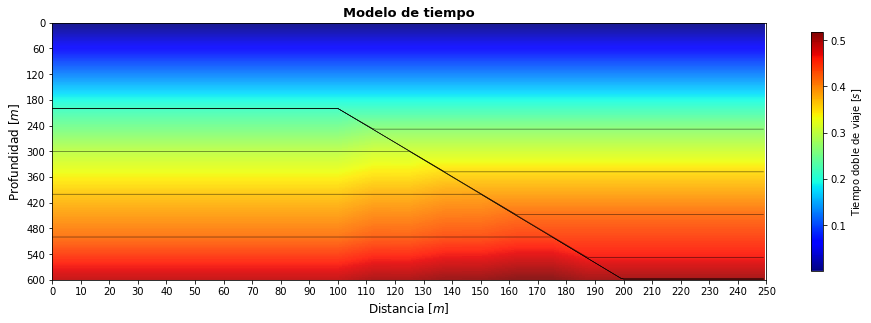

In [19]:
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(111)

im = plt.imshow( modelo_tz, cmap='jet', alpha = 0.9, aspect = 0.15)
cbar = plt.colorbar(shrink = 0.55)
cbar.set_label('Tiempo doble de viaje $[s]$', weight = 'normal')
_ = plt.title('Modelo de tiempo', fontsize = 13, weight = 'semibold' )
_ = plt.xlabel('Distancia $[m]$', fontsize = 12, weight = 'normal')
_ = plt.ylabel('Profundidad $[m]$', fontsize = 12, weight = 'normal')
_ = plt.xticks(np.linspace(0,250,26))
_ = plt.yticks(np.linspace(0,600,11))
modelo_geo(ax, hor1, hor2, hor3, hor4, hor5, hor6, hor7, hor8, **geometria)

#### Determinanción del máximo del tiempo doble de viaje

In [20]:
tz_max = np.amax(modelo_tz)

In [21]:
print ('Máximo valor de t:', np.round(tz_max * 1000,3), '[s]')

Máximo valor de t: 518.205 [s]


#### Dimensiones del modelo de falla en el dominio de la profundidad y tiempo

In [22]:
zx = np.arange(0, 600, 1)
hx = np.arange(0, 1000/4, 1)

In [23]:
zx_sca = np.arange(0, 600 , 1.16)
hx_sca = np.arange(0, 250, 1)
extent = 0, 125, 404, 0

In [24]:
print('Número de muestras en el eje vertical (tiempo):', zx_sca.shape, '[s]')

Número de muestras en el eje vertical (tiempo): (518,) [s]


In [25]:
print('Unidades en la dirección vertical y horizontal, modelo M:', len(zx), 'y', len(hx), '.')
print('Unidades en la dirección vertical y horizontal, modelo N:', len(zx_sca), 'y', len(hx_sca), '.')

Unidades en la dirección vertical y horizontal, modelo M: 600 y 250 .
Unidades en la dirección vertical y horizontal, modelo N: 518 y 250 .


In [26]:
inter_vel = interpolate.interp2d(hx, zx, modelo_vel, kind='quintic')
inter_imp = interpolate.interp2d(hx, zx, modelo_imp, kind='quintic')

In [27]:
sca_vel = inter_vel(hx_sca,zx_sca)
sca_imp = inter_imp(hx_sca,zx_sca)

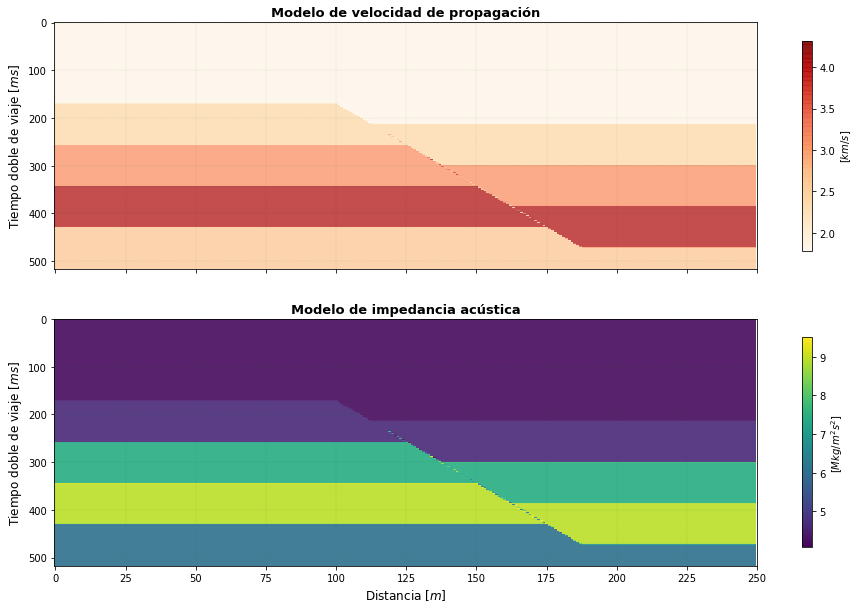

In [28]:
fig = plt.figure(figsize=[16,10])

ax = fig.add_subplot(211)
plt.imshow(sca_vel/1000, cmap = 'OrRd', alpha=0.7, aspect = 0.17)
cbar = plt.colorbar(shrink = 0.85)
cbar.set_label('$[km/s]$', fontsize = 10, weight = 'normal')
_ = plt.title('Modelo de velocidad de propagación', fontsize = 13, weight = 'semibold')
_ = plt.ylabel('Tiempo doble de viaje $[ms]$', fontsize = 12, weight = 'normal')
_ = plt.xticks(np.linspace(0,250,11))
ax.set_xticklabels('')
_ = plt.grid(True, alpha = 0.2, lw = 0.4, color = 'g', ls = '--')

ax = fig.add_subplot(212)
im = plt.imshow(sca_imp/1000000, cmap = 'viridis', alpha = 0.9, aspect = 0.17)
cbar = plt.colorbar(shrink = 0.85)
cbar.set_label('$[Mkg/m^2s^2]$', fontsize = 10, weight = 'normal')
_ = plt.title('Modelo de impedancia acústica', fontsize = 13, weight = 'semibold')
_ = plt.ylabel('Tiempo doble de viaje $[ms]$', fontsize = 12, weight = 'normal')
_ = plt.xticks(np.linspace(0,250,11))
_ = plt.xlabel('Distancia $[m]$', fontsize = 12, weight = 'normal')
_ = plt.grid(True, alpha = 0.2, lw = 0.4, color = 'g', ls = '--')

In [29]:
sr_t = (sca_imp[1:] - sca_imp[:-1]) / (sca_imp[1:] + sca_imp[:-1])
maxsr_t = np.round(np.amax(abs(sr_t)),3)

In [30]:
print('Valor máximo de reflectividad', maxsr_t, '[1]')

Valor máximo de reflectividad 0.352 [1]


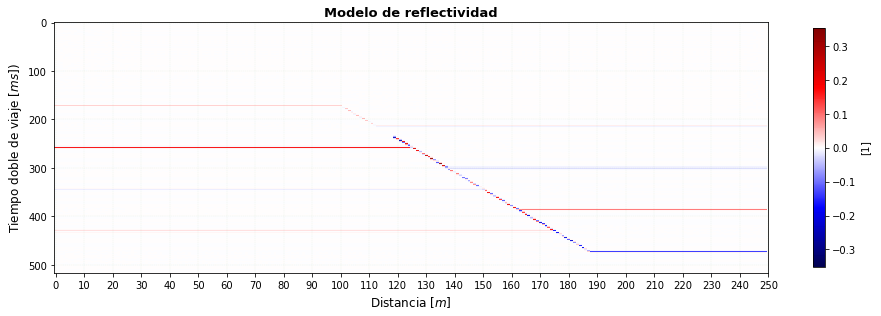

In [31]:
fig = plt.figure(figsize=[16,8])

ax = fig.add_subplot(111)
im = plt.imshow(sr_t, cmap = 'seismic', vmax = maxsr_t, vmin = - maxsr_t, alpha = 0.9, aspect = 0.17)
cbar = plt.colorbar(shrink = 0.55)
cbar.set_label('$[1]$', fontsize = 10, weight = 'normal')
_ = plt.title('Modelo de reflectividad', fontsize = 13, weight = 'semibold')
_ = plt.xlabel('Distancia $[m]$', fontsize = 12)
_ = plt.ylabel('Tiempo doble de viaje $[ms]$)', fontsize = 12)
_ = plt.xticks(np.linspace(0,250,26))
_ = plt.grid(True, alpha = 0.1, lw = 0.4, color = 'g', ls = '--')

In [32]:
sr_params = {'vmax':maxsr_t,'vmin':-maxsr_t}

In [33]:
def ricker_w(f): 
    return ricker(0.360, 0.001, f)

def conv(a):
    return np.convolve(ricker_w(f), a, mode='same')

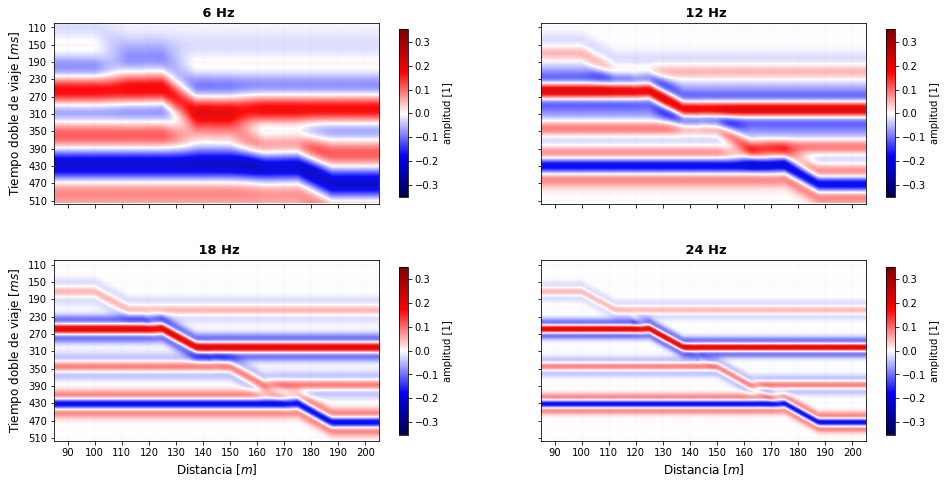

In [34]:
fig = plt.figure(figsize=[16,8])

ax = fig.add_subplot(221)
f = 6
seccion = np.apply_along_axis(conv, 0, sr_t)
im = plt.imshow(seccion, **sr_params, cmap = 'seismic', interpolation='gaussian', aspect = 0.16, alpha = 0.95)
cbar = plt.colorbar(shrink = 0.85)
cbar.set_label('amplitud [1]', fontsize = 10, weight = 'normal')
_ = plt.title(  f' {f} Hz', fontsize = 13, weight = 'semibold')
ax.set_xticklabels('')
_ = plt.ylabel('Tiempo doble de viaje $[ms]$', fontsize = 12, weight = 'normal')
_ = plt.xticks(np.linspace(0,250,26))
_ = plt.yticks(np.linspace(110,510,11))
_ = plt.xlim(85,205)
_ = plt.ylim(517,100)
_ = plt.grid(True, alpha = 0.1, lw = 0.4, color = 'g', ls = '--')

ax = fig.add_subplot(222)
f = 12
seccion = np.apply_along_axis(conv, 0, sr_t)
im = plt.imshow(seccion, **sr_params, cmap = 'seismic', interpolation='gaussian', aspect = 0.16, alpha = 0.95)
cbar = plt.colorbar(shrink = 0.85)
cbar.set_label('amplitud [1]', fontsize = 10, weight = 'normal')
_ = plt.title(  f' {f} Hz', fontsize = 13, weight = 'semibold')
ax.set_xticklabels('')
ax.set_yticklabels('')
_ = plt.xticks(np.linspace(0,250,26))
_ = plt.yticks(np.linspace(110,510,11))
_ = plt.xlim(85,205)
_ = plt.ylim(517,100)
_ = plt.grid(True, alpha = 0.1, lw = 0.4, color = 'g', ls = '--')

ax = fig.add_subplot(223)
f = 18
seccion = np.apply_along_axis(conv, 0, sr_t)
im = plt.imshow(seccion, **sr_params, cmap = 'seismic', interpolation='gaussian', aspect = 0.16, alpha = 0.95)
cbar = plt.colorbar(shrink = 0.85)
cbar.set_label('amplitud [1]', fontsize = 10, weight = 'normal')
_ = plt.title(  f' {f} Hz', fontsize = 13, weight = 'semibold')
_ = plt.xlabel('Distancia $[m]$', fontsize = 12, weight = 'normal')
_ = plt.ylabel('Tiempo doble de viaje $[ms]$', fontsize = 12, weight = 'normal')
_ = plt.xticks(np.linspace(0,250,26))
_ = plt.yticks(np.linspace(110,510,11))
_ = plt.xlim(85,205)
_ = plt.ylim(517,100)
_ = plt.grid(True, alpha = 0.1, lw = 0.4, color = 'g', ls = '--')

ax = fig.add_subplot(224)
f = 24
seccion = np.apply_along_axis(conv, 0, sr_t)
im = plt.imshow(seccion, **sr_params, cmap = 'seismic', interpolation='gaussian', aspect = 0.16, alpha = 0.95)
cbar = plt.colorbar(shrink = 0.85)
cbar.set_label('amplitud [1]', fontsize = 10, weight = 'normal')
_ = plt.title(  f' {f} Hz', fontsize = 13, weight = 'semibold')
_ = plt.xlabel('Distancia $[m]$', fontsize = 12, weight = 'normal')
ax.set_yticklabels('')
_ = plt.xticks(np.linspace(0,250,26))
_ = plt.yticks(np.linspace(110,510,11))
_ = plt.xlim(85,205)
_ = plt.ylim(517,100)
_ = plt.grid(True, alpha = 0.1, lw = 0.4, color = 'g', ls = '--')

### Trabajo a futuro

1. Gradiente de velocidad vertical
2. Analizar el efecto de la longitud de la ondícula
3. Implementar diferentes ondículas: Butterworth, Ormsby
4. Con base en el inciso 1), calcular la ventana operativa bajo un régimen de esfuerzo normal
5. Incorporar ruido aleatorio